## Mizo to English Textual Translation using Neural Machine Translation

Smaller dataset of 2216 which is split into 75% train and 25% test set.

### 1. Import the required packages

In [1]:
import string
import re
import tensorflow as tf
from numpy import array, argmax
from numpy.random import rand
from numpy.random import shuffle
from keras import layers
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Bidirectional
from keras.layers import Embedding, RepeatVector, TimeDistributed, BatchNormalization
from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from pickle import dump, load
from unicodedata import normalize
from nltk.translate.bleu_score import corpus_bleu
from sacrebleu.metrics import BLEU
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### 2. Important functions

In [2]:
def save_tokenizer(tokenizer, filename):
    dump(tokenizer, open(filename, 'wb'))
    print('Saved tokenizer: %s' % filename)
    
def load_doc(filename):
  # open the file as read only
  file = open(filename, mode='rt', encoding='latin-1') #encoding='utf-8'
  # read all text
  text = file.read()
  #close the file
  file.close()
  return text

def to_pairs(doc):
  lines = doc.strip().split('\n')
  pairs = [line.split('\t') for line in lines]
  return pairs

def clean_pairs(lines):
  cleaned = list()
  # Prepare regex for char filtering
  re_print = re.compile('[^%s]' % re.escape(string.printable))
  # Prepare translation table for removing punctuation
  table = str.maketrans('', '', string.punctuation)
  for pair in lines:
    clean_pair = list()
    for line in pair:
      # Normalize unicode characters
      line = normalize('NFD', line).encode('ascii', 'ignore')
      line = line.decode('UTF-8')
      # Tokenize on white space
      line = line.split()
      # Convert to lowercase
      line = [word.lower() for word in line]
      # Remove punctuation from each token
      line = [word.translate(table) for word in line]
      # Remove non-printable characters from each token
      line = [re_print.sub('', w) for w in line]
      # Remove tokens with numbers in them
      # line = [word for word in line if word.isalpha()]
      # Store as string
      clean_pair.append(' '.join(line))
    cleaned.append(clean_pair)
  return array(cleaned)

def load_clean_sentences(filename):
  return load(open(filename, 'rb'))

def save_clean_data(sentences, filename):
  dump(sentences, open(filename, 'wb'))
  print('Saved: %s' % filename)
    
def create_tokenizer(lines):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

def max_length(lines):
  return max(len(line.split()) for line in lines)

def encode_sequences(tokenizer, length, lines):
  # Integer encode sequences
  X = tokenizer.texts_to_sequences(lines)
  # Pad sequences with 0 values
  X = pad_sequences(X, maxlen=length, padding='post')
  return X

def encode_output(sequences, vocab_size):
  ylist = list()
  for sequence in sequences:
    encoded = to_categorical(sequence, num_classes = vocab_size)
    ylist.append(encoded)
  y = array(ylist)
  y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
  return y

### 3. Loading data and splitting

In [3]:
# Load dataset
filename = 'mizo_english_corpus.txt' #'English-Mizo.txt'
doc = load_doc(filename)

# Split into Mizo - English pairs
pairs = to_pairs(doc)

# Clean sentences
clean_pairs = clean_pairs(pairs)

# Save clean pairs to file
# save_clean_data(clean_pairs, 'cleandata.pkl')

# Number of samples
n_sentences = 2200

dataset = clean_pairs

# Load dataset
# dataset = load_clean_sentences('cleandata.pkl')

#Limit the dataset
dataset = dataset[:n_sentences,:]
print("Length of dataset", len(dataset))

# Random Shuffle
shuffle(dataset)

# Split into train and test set
train, test = dataset[:1650], dataset[1650:]

print("Length of train", len(train))
print("Length of test", len(test))

Length of dataset 2200
Length of train 1650
Length of test 550


#### 3.1 Prepare Mizo  and English Tokenizer

In [4]:
miz_tokenizer = create_tokenizer(dataset[:,0])
miz_vocab_size = len(miz_tokenizer.word_index) + 1
miz_length = max_length(dataset[:,0])
print("MIZO")
print("Mizo Vocabulary Size: %d" % miz_vocab_size)
print("Mizo longest sentence: %d" % (miz_length))
print("Sample Mizo sentences\n",dataset[:,0])

eng_tokenizer = create_tokenizer(dataset[:,1])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 1])
print("\n\nENGLISH")
print("English Vocabulary Size: %d" % eng_vocab_size)
print("English longest sentence: %d" % (eng_length))
print("Sample English sentences\n",dataset[:,1])

# Save tokenizers
save_tokenizer(miz_tokenizer, 'mizo_tokenizer.pkl')
print("Mizo Tokenizer Saved")
save_tokenizer(eng_tokenizer, 'eng_tokenizer.pkl')
print("English Tokenizer Saved")

MIZO
Mizo Vocabulary Size: 987
Mizo longest sentence: 5
Sample Mizo sentences
 ['zu a rui' 'awmpui a nei' 'i tan a ni' ... 'ka thlen a ni' 'i chak ta em'
 'i tanleh ang u']


ENGLISH
English Vocabulary Size: 1240
English longest sentence: 6
Sample English sentences
 ['he is drunk' 'he has a maid' 'its for you' ... 'i caused this'
 'did you win' 'lets start again']
Saved tokenizer: mizo_tokenizer.pkl
Mizo Tokenizer Saved
Saved tokenizer: eng_tokenizer.pkl
English Tokenizer Saved


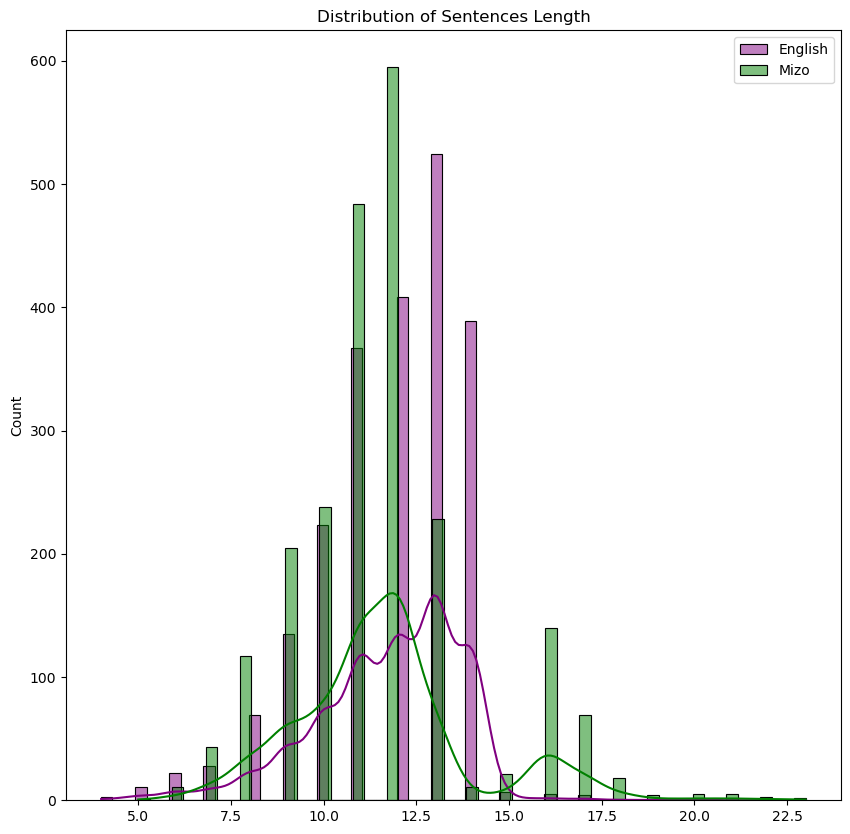

In [5]:
plt.figure(figsize = (10,10))

sns.histplot([len(x) for x in dataset[:,0]], color='purple', kde=True, label='English')
sns.histplot([len(x) for x in dataset[:,1]], color='green', kde=True, label='Mizo')
plt.title('Distribution of Sentences Length')
plt.legend()
plt.show()

<Figure size 1000x1000 with 0 Axes>

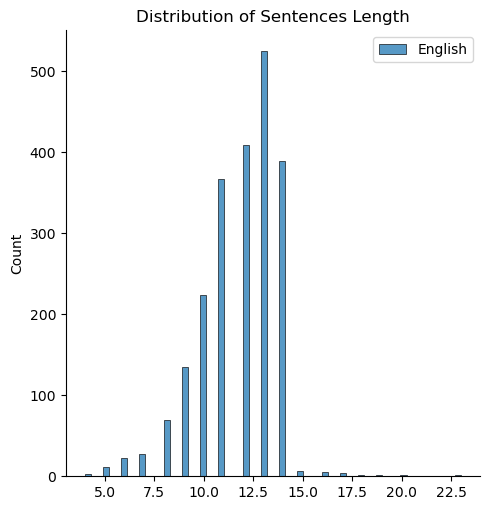

In [6]:
plt.figure(figsize = (10,10))
sns.displot([len(x) for x in dataset[:,0]], label='English')
#sns.displot([len(x) for x in dataset[:,1]], label='Mizo')

plt.title('Distribution of Sentences Length')
plt.legend()
plt.show()

<Figure size 1500x1500 with 0 Axes>

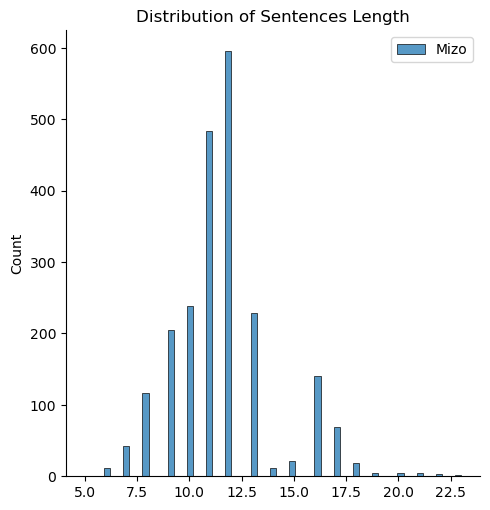

In [7]:
plt.figure(figsize = (15,15))
#sns.distplot([len(x) for x in dataset[:,0]], label='English')
sns.displot([len(x) for x in dataset[:,1]], label='Mizo')

plt.title('Distribution of Sentences Length')
plt.legend()
plt.show()

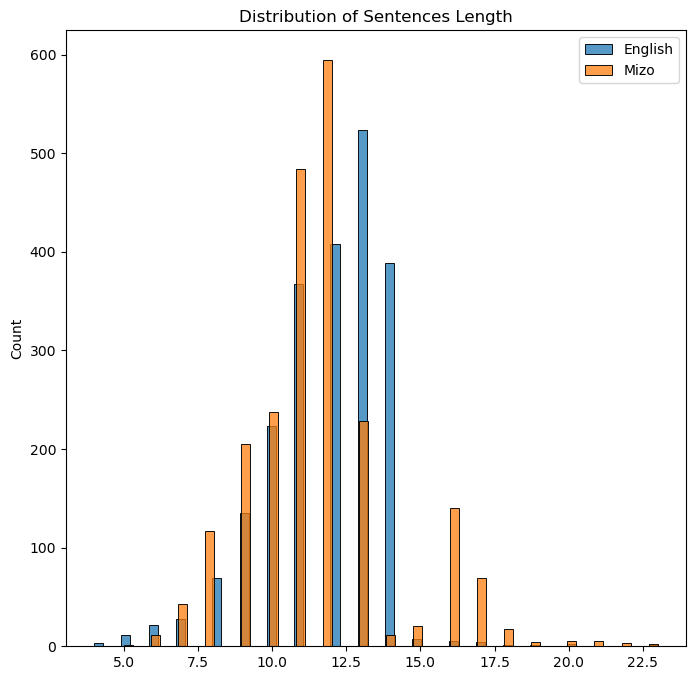

In [8]:
plt.figure(figsize = (8,8))
sns.histplot([len(x) for x in dataset[:,0]], label='English')
sns.histplot([len(x) for x in dataset[:,1]], label='Mizo')

plt.title('Distribution of Sentences Length')
plt.legend()
plt.show()

#### 3.2 Prepare training data

In [9]:
trainX = encode_sequences(miz_tokenizer, miz_length, train[:, 0])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 1])
trainY = encode_output(trainY, eng_vocab_size)

#### 3.3 Prepare validation and test data

In [10]:
testX = encode_sequences(miz_tokenizer, miz_length, test[:, 0])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 1])
testY = encode_output(testY, eng_vocab_size)

### 4. Define and call the model and display summary - BiLSTM

In [11]:
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
  model = keras.Sequential()
  model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
  model.add(BatchNormalization())
  model.add(Bidirectional(LSTM(n_units)))
  model.add(BatchNormalization())
  model.add(RepeatVector(tar_timesteps))
  model.add(Bidirectional(LSTM(n_units, return_sequences=True)))
  model.add(BatchNormalization())
  model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
  return model


opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# Call the define model function
model = define_model(miz_vocab_size, eng_vocab_size, miz_length, eng_length, 256)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Summarize the defined model
print(model.summary())

#plot model
plot_model(model, to_file='model.eps', show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5, 256)            252672    
                                                                 
 batch_normalization (BatchN  (None, 5, 256)           1024      
 ormalization)                                                   
                                                                 
 bidirectional (Bidirectiona  (None, 512)              1050624   
 l)                                                              
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 repeat_vector (RepeatVector  (None, 6, 512)           0         
 )                                                      

### 5. Fit and train the model

In [12]:
filename = 'mizen_using_bilstm_model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model.fit(trainX, trainY, epochs=30, batch_size=32, validation_data=(testX, testY), callbacks=[checkpoint])

Epoch 1/30
52/52 [==============================] - ETA: 0s - loss: 4.0680 - accuracy: 0.4447
Epoch 1: val_loss improved from inf to 3.55814, saving model to mizen_using_bilstm_model.h5
52/52 [==============================] - 14s 85ms/step - loss: 4.0680 - accuracy: 0.4447 - val_loss: 3.5581 - val_accuracy: 0.6018
Epoch 2/30
52/52 [==============================] - ETA: 0s - loss: 1.9514 - accuracy: 0.6764
Epoch 2: val_loss improved from 3.55814 to 3.21898, saving model to mizen_using_bilstm_model.h5
52/52 [==============================] - 1s 20ms/step - loss: 1.9514 - accuracy: 0.6764 - val_loss: 3.2190 - val_accuracy: 0.6061
Epoch 3/30
49/52 [===========================>..] - ETA: 0s - loss: 1.3806 - accuracy: 0.7218
Epoch 3: val_loss improved from 3.21898 to 3.09094, saving model to mizen_using_bilstm_model.h5
52/52 [==============================] - 1s 18ms/step - loss: 1.3799 - accuracy: 0.7218 - val_loss: 3.0909 - val_accuracy: 0.6079
Epoch 4/30
49/52 [=========================

52/52 [==============================] - 1s 17ms/step - loss: 0.0684 - accuracy: 0.9836 - val_loss: 2.5864 - val_accuracy: 0.6894
Epoch 30/30
49/52 [===========================>..] - ETA: 0s - loss: 0.0562 - accuracy: 0.9875
Epoch 30: val_loss did not improve from 2.20332
52/52 [==============================] - 1s 17ms/step - loss: 0.0568 - accuracy: 0.9874 - val_loss: 2.6050 - val_accuracy: 0.6879


### 6. Evaluate the Neural Machine Translation Model

In [13]:
# map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# generate target given source sequence
def predict_sequence(model, tokenizer, source):
    prediction = model.predict(source, verbose=0)[0]
    integers = [argmax(vector) for vector in prediction]
    target = list()
    for i in integers:
        word = word_for_id(i, tokenizer)
        if word is None:
            break
        target.append(word)
    return ' '.join(target)

# evaluate the skill of the model
def evaluate_model(model, tokenizer, sources, raw_dataset):
    actual, predicted = list(), list()
    for i, source in enumerate(sources):
        # translate encoded source text
        source = source.reshape((1, source.shape[0]))
        translation = predict_sequence(model, eng_tokenizer, source)
        raw_src, raw_target = raw_dataset[i]
        if i < 10:
            print('src=[%s], target=[%s], predicted=[%s]' % (raw_src, raw_target, translation))
        actual.append([raw_target.split()])
        predicted.append(translation.split())
    
    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))
    print('Final BLEU score: %f' % corpus_bleu(actual, predicted))
    
# Load model
model = load_model('mizen_using_bilstm_model.h5')

# Evaluate the model
print("\nUSING TRAINING DATA")
evaluate_model(model, miz_tokenizer, trainX, train)

# Test on some test sequences
print("\nUSING TEST DATA")
evaluate_model(model, miz_tokenizer, testX, test)


USING TRAINING DATA
src=[zu a rui], target=[he is drunk], predicted=[he is]
src=[awmpui a nei], target=[he has a maid], predicted=[he has a]
src=[i tan a ni], target=[its for you], predicted=[its for]
src=[a mak hle mai], target=[its very strange], predicted=[its very]
src=[a mawlmang hle], target=[he was naive], predicted=[he was naive]
src=[ka ei a ngai], target=[i need to eat], predicted=[i to to]
src=[cheese ka ei], target=[i eat cheese], predicted=[i eat cheese]
src=[ka ring a lawm], target=[i believe it], predicted=[i you]
src=[i lam thei em], target=[do you dance], predicted=[do you dance]
src=[tawp san suh], target=[dont give up], predicted=[dont give]
BLEU-1: 0.819945
BLEU-2: 0.776220
BLEU-3: 0.591500
BLEU-4: 0.130403
Final BLEU score: 0.130403

USING TEST DATA
src=[lo lut rawh], target=[come inside], predicted=[come come in]
src=[hmingchhiatna], target=[bad reputation], predicted=[lets zawng]
src=[buaina awm lo], target=[no problem], predicted=[no problem]
src=[ka tla lo], t

C:\Users\Maruata\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


### 7. Plot different graphs of the model

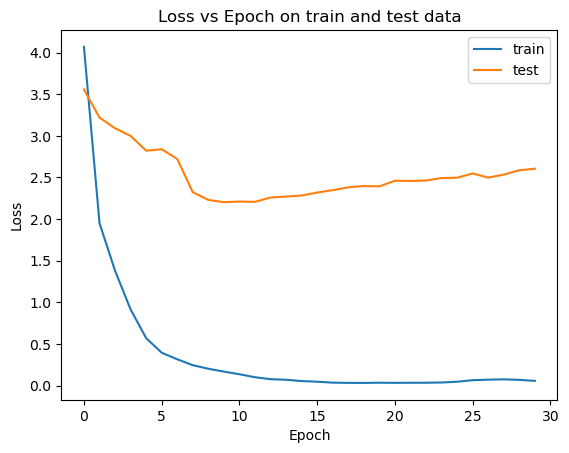

In [14]:
# importing library for plotting
import matplotlib.pyplot as plt
import seaborn as sn

# Plot of loss vs epoch of train and test dataset
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss vs Epoch on train and test data")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
#plt.savefig('plots/ae_binary_loss.png')
plt.show()

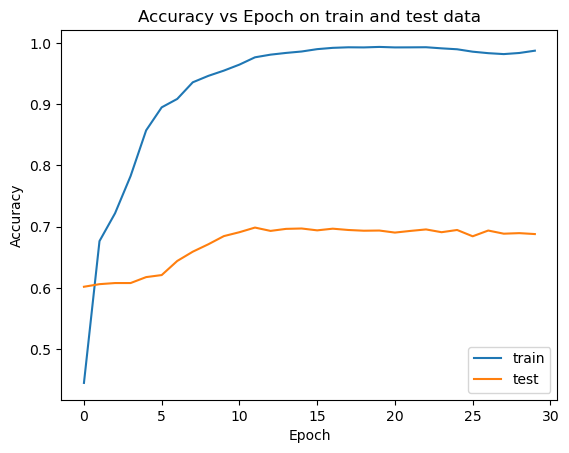

In [15]:
# Plot of loss vs epoch of train and test dataset
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy vs Epoch on train and test data")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')
#plt.savefig('plots/ae_binary_loss.png')
plt.show()

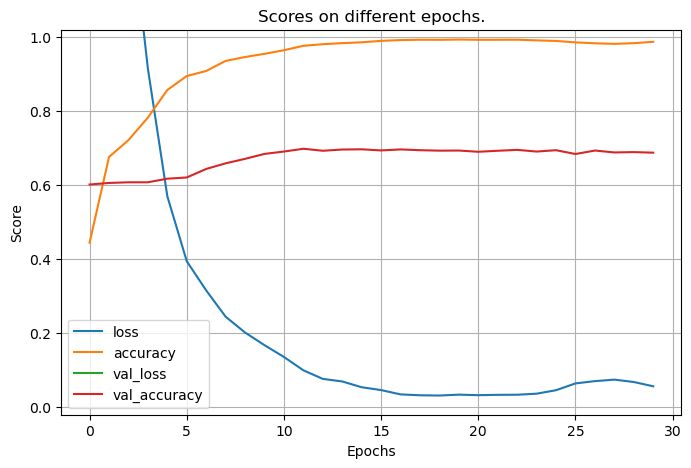

In [16]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(-0.02,1.02)
plt.title('Scores on different epochs.')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.show()

# Important function to process input and translate sentence

In [27]:
#working to translate on hand
def preprocess_input(sentence, tokenizer, max_length):
    sentence = normalize('NFD', sentence).encode('ascii', 'ignore')
    sentence = sentence.decode('latin-1')
    sentence = sentence.split()
    sentence = [word.lower() for word in sentence]
    sentence = [word.translate(str.maketrans('', '', string.punctuation)) for word in sentence]
    sentence = [re.sub('[^a-zA-Z]', '', word) for word in sentence]
    sentence = ' '.join(sentence)
    sentence = [sentence]
    sentence = tokenizer.texts_to_sequences(sentence)
    sentence = pad_sequences(sentence, maxlen=max_length, padding='post')
    return sentence

# Function to translate the input sentence
def translate_sentence(model, mizo_tokenizer, eng_tokenizer, sentence):
    max_length_mizo = model.input_shape[1]
    sentence = preprocess_input(sentence, mizo_tokenizer, max_length_mizo)
    translation = model.predict(sentence, verbose=0)[0]
    integers = [argmax(vector) for vector in translation]
    target = []
    for i in integers:
        word = word_for_id(i, eng_tokenizer)
        if word is None:
            break
        target.append(word)
    return ' '.join(target)

In [28]:
# Load the saved model
model = load_model('mizen_using_bilstm_model.h5')

# Function to load the Mizo tokenizer
def load_mizo_tokenizer():
    return load(open('mizo_tokenizer.pkl', 'rb'))

# Function to load the English tokenizer
def load_eng_tokenizer():
    return load(open('eng_tokenizer.pkl', 'rb'))

In [29]:
# Load tokenizers
mizo_tokenizer = load_mizo_tokenizer()
eng_tokenizer = load_eng_tokenizer()

In [37]:
# Prompt user for a Mizo sentence
user_input = input("Enter a Mizo sentence: ")

# Translate the entered sentence
translation = translate_sentence(model, mizo_tokenizer, eng_tokenizer, user_input)

# Display the translation
print("English Translation:", translation)

Enter a Mizo sentence: ka hre lo
English Translation: i didnt know
